# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: [Jian Hui Mai]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import tensorflow.keras as tk
import keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
cifar10 = tk.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    return np.eye(num_class)[y.reshape(-1)]

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
# Randomize 50,000 numbers and place into array
random = np.random.permutation(50000)

# Retrieve rows 0 to 39999 indicies to create training set
x_tr = x_train[random[0:40000], :, :, :]
y_tr = y_train_vec[random[0:40000], :]

# Retrieve rows 40000 to 49999 indicies to create training set
x_val = x_train[random[40000:50000], :, :, :]
y_val = y_train_vec[random[40000:50000], :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
from keras import layers, activations, models

# Build the model
model = models.Sequential()
# Conv of 32@3x3 to generate 32@30x30
model.add(layers.Conv2D(32, (3,3), input_shape=(32,32,3)))
# ReLu Activation for Conv
model.add(layers.Activation(activations.relu))
# Max Pooling of 2x2 to generate 32@15x15
model.add(layers.MaxPooling2D(2,2))
# Conv of 64@4x4 to generate 64@12x12
model.add(layers.Conv2D(64, (4,4)))
# ReLu Activation for Conv
model.add(layers.Activation(activations.relu))
# Max pooling of 2x2 to generate 64@6x6
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
# Dense layer of 1x256
model.add(layers.Dense(256))
# ReLU Activation for dense layer
model.add(layers.Activation(activations.relu))
# Dense layer of 1x10
model.add(layers.Dense(10))
# Softmax activation function for dense layer
model.add(layers.Activation(activations.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [5]:
# Define model optimizer and loss function
from tensorflow import keras
from keras import optimizers
# Compile model with 0.001 learning rate, loss of Categorical Crossentropy
model.compile(keras.optimizers.RMSprop(learning_rate=0.001), loss = 'CategoricalCrossentropy', 
              metrics=['accuracy'])

In [6]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr, batch_size = 128, epochs = 20, validation_data=(x_val, y_val))

Epoch 1/20
313/313 [==============================] - 11s 33ms/step - loss: 4.5680 - accuracy: 0.2165 - val_loss: 1.8606 - val_accuracy: 0.3344
Epoch 2/20
313/313 [==============================] - 11s 34ms/step - loss: 1.8270 - accuracy: 0.3744 - val_loss: 1.9429 - val_accuracy: 0.3587
Epoch 3/20
313/313 [==============================] - 11s 34ms/step - loss: 1.4946 - accuracy: 0.4872 - val_loss: 1.3338 - val_accuracy: 0.5353
Epoch 4/20
313/313 [==============================] - 11s 34ms/step - loss: 1.2730 - accuracy: 0.5642 - val_loss: 1.4524 - val_accuracy: 0.5014
Epoch 5/20
313/313 [==============================] - 10s 33ms/step - loss: 1.1034 - accuracy: 0.6259 - val_loss: 1.3889 - val_accuracy: 0.5514
Epoch 6/20
313/313 [==============================] - 11s 35ms/step - loss: 0.9643 - accuracy: 0.6737 - val_loss: 1.1930 - val_accuracy: 0.6118
Epoch 7/20
313/313 [==============================] - 11s 35ms/step - loss: 0.8284 - accuracy: 0.7186 - val_loss: 1.3365 - val_accuracy:

## 3. Plot the training and validation loss curve versus epochs. (5 points)

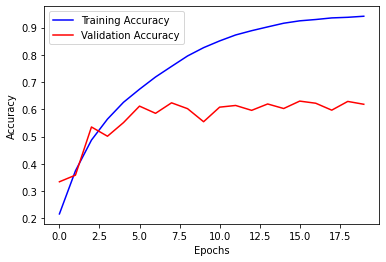

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Retrieve train accuracy
train_accuracy = history.history['accuracy']
# Used to retrieve number of epochs
epochs = range(len(train_accuracy))
# Retrieve validation accuracy
validation_accuracy = history.history['val_accuracy']
# Plot accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [8]:
# Compile model with 0.001 learning rate and Categorical Crossentropy
model.compile(keras.optimizers.RMSprop(learning_rate=0.001), loss = 'CategoricalCrossentropy', 
              metrics=['accuracy'])

In [9]:
# Train model with the whole training set
history1_1 = model.fit(x_train, y_train_vec, batch_size = 128, epochs = 20)

Epoch 1/20
391/391 [==============================] - 12s 31ms/step - loss: 0.7620 - accuracy: 0.8273
Epoch 2/20
391/391 [==============================] - 12s 31ms/step - loss: 0.5288 - accuracy: 0.8590
Epoch 3/20
391/391 [==============================] - 12s 32ms/step - loss: 0.4152 - accuracy: 0.8841
Epoch 4/20
391/391 [==============================] - 13s 32ms/step - loss: 0.3691 - accuracy: 0.8965
Epoch 5/20
391/391 [==============================] - 12s 32ms/step - loss: 0.3361 - accuracy: 0.9060
Epoch 6/20
391/391 [==============================] - 12s 32ms/step - loss: 0.3092 - accuracy: 0.9145
Epoch 7/20
391/391 [==============================] - 12s 32ms/step - loss: 0.2983 - accuracy: 0.9183
Epoch 8/20
391/391 [==============================] - 12s 31ms/step - loss: 0.2840 - accuracy: 0.9244
Epoch 9/20
391/391 [==============================] - 12s 32ms/step - loss: 0.2673 - accuracy: 0.9287
Epoch 10/20
391/391 [==============================] - 12s 32ms/step - loss: 0.261

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

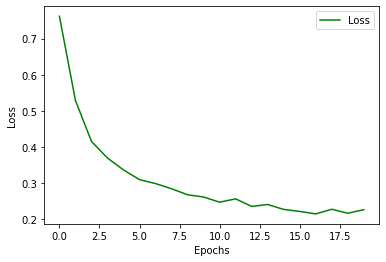

313/313 [==============================] - 1s 2ms/step - loss: 5.5940 - accuracy: 0.6244
Loss = 5.59
Accuracy = 0.62


In [10]:
loss = history1_1.history['loss']
# Retrieve number of epochs
epochs = range(len(loss))
# Plot the accuracy
plt.plot(epochs, loss, 'g', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate your model performance (testing accuracy) on testing data.
testing_accuracy = model.evaluate(x_test, y_test_vec)
# Print the loss and accuracy
print('Loss = ' + str(round(testing_accuracy[0],2)))
print('Accuracy = ' + str(round(testing_accuracy[1],2)))

## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at least two different model structures.

In [11]:
from tensorflow.keras.layers import BatchNormalization

model2 = models.Sequential()
# Conv of 32@3x3 to generate 32@30x30
model2.add(layers.Conv2D(32, (3,3), input_shape=(32,32,3)))
# ReLu activation for Conv
model2.add(layers.Activation(activations.relu))
# Max pooling of 2x2 to generate 32@15x15
model2.add(layers.MaxPooling2D(2,2))
# Conv of 64@4x4 to generate 64@12x12
model2.add(layers.Conv2D(64, (4,4)))
# Apply Batch Normalization to Conv Layer
model2.add(BatchNormalization())
# Apply ReLu activation to Conv
model2.add(layers.Activation(activations.relu))
# Max Pooling 2x2 to generate 64@6x6
model2.add(layers.MaxPooling2D(2,2))
# Flatten layer
model2.add(layers.Flatten())
# Dense layer of 1x256
model2.add(layers.Dense(256))
# Apply Batch Normalization to Dense Layer
model2.add(BatchNormalization())
# ReLu activation Function for Dense Layer
model2.add(layers.Activation(activations.relu))
# Dense layer of 1x10
model2.add(layers.Dense(10))
# Softmax activation Function for Dense Layer
model2.add(layers.Activation(activations.softmax))
model2.summary()

model2.compile(keras.optimizers.RMSprop(learning_rate=0.001), 
               loss = 'CategoricalCrossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train_vec, batch_size = 128, epochs = 20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 activation_5 (Activation)   (None, 12, 12, 64)       

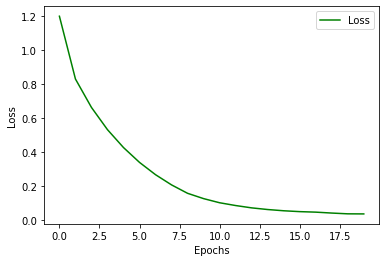

313/313 [==============================] - 1s 3ms/step - loss: 1.5463 - accuracy: 0.7177
Loss = 1.55
Accuracy = 0.72


In [12]:
# Plot the loss curve
loss = history2.history['loss']
# Retrieve number of epochs
epochs = range(len(loss))
# Plot the accuracy
plt.plot(epochs, loss, 'g', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Retrieve and print testing accuracy
testing_accuracy2 = model2.evaluate(x_test, y_test_vec)
print('Loss = ' + str(round(testing_accuracy2[0],2)))
print('Accuracy = ' + str(round(testing_accuracy2[1],2)))

#### Compared to the original model, the model with Batch Normalization has a better test set accuracy and a significantly lower loss.

#### Comparing the loss curves, the original model starts at a lower loss value but ends up in a higher loss value than the Batch Normalization model.

In [13]:
model3 = models.Sequential()
# Conv of 32@3x3 to generate 32@30x30
model3.add(layers.Conv2D(32, (3,3), input_shape=(32,32,3)))
# ReLu activation function for Conv
model3.add(layers.Activation(activations.relu))
# 2x2 Max Pooling to generate 32@15x15
model3.add(layers.MaxPooling2D(2,2))
# Conv of 64@4x4 to generate 64@12x12
model3.add(layers.Conv2D(64, (4,4)))
# ReLu Activation function for Conv
model3.add(layers.Activation(activations.relu))
# 2x2 Max Pooling to generate 64@6x6
model3.add(layers.MaxPooling2D(2,2))
# Flatten layer
model3.add(layers.Flatten())
# 0.5 Dropout layer
model3.add(layers.Dropout(0.5))
# 1*256 dense layer
model3.add(layers.Dense(256))
# ReLu Activation function for dense layer
model3.add(layers.Activation(activations.relu))
# 1*10 dense layer 
model3.add(layers.Dense(10))
# Softmax Activation function for dense layer
model3.add(layers.Activation(activations.softmax))
model3.summary()

model3.compile(keras.optimizers.RMSprop(learning_rate=0.001), 
               loss = 'CategoricalCrossentropy', metrics=['accuracy'])
history3 = model3.fit(x_train, y_train_vec, batch_size = 128, epochs = 20)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_9 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

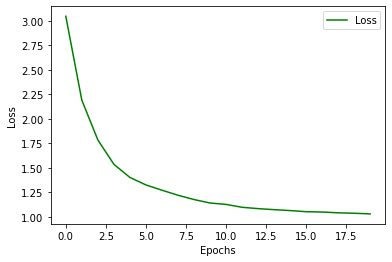

313/313 [==============================] - 1s 3ms/step - loss: 1.0199 - accuracy: 0.6637
Loss = 1.02
Accuracy = 0.66


In [14]:
# Plot the loss curve
loss = history3.history['loss']
# Retrieve number of epochs
epochs = range(len(loss))
plt.plot(epochs, loss, 'g', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Retrieve and print testing accuracy
testing_accuracy3 = model3.evaluate(x_test, y_test_vec)
print('Loss = ' + str(round(testing_accuracy3[0],2)))
print('Accuracy = ' + str(round(testing_accuracy3[1],2)))

#### Compared to the original model, the model with dropout has the higher testing set accuracy and has a signficantly lower loss.


#### Comparing the loss curves, the original model starts at a lower loss value and ends up in a lower loss value than the model with dropout.